## Warning

The second half of the Notebook deals with Audio Splitting, and uses a library called 'webrtcvad'. 
This library only runs on linux-based machines (use POSIX systems, Google Colab or a Virtual machine)

## Required pip installs

In [ ]:
!pip install pydub spectralcluster webrtcvad youtube_dl

## Required Imports

In [33]:
import pandas as pd
import seaborn as sns

from pydub import AudioSegment
import os
import math
from pathlib import Path
from tqdm.notebook import tqdm
import librosa

## Data PreProcessing

In [3]:
link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQp3KbscscbTJyVAWHuQY_srKz3M2GvWcmg6Sh1sz7Wn97yjtPbLCtXrc3Any4QC48l29ARWPPSEf4n/pub?gid=312053380&single=true&output=csv'

In [12]:
df = pd.read_csv(link)

In [13]:
df.head()

,url,name,gender,age
0,https://www.youtube.com/watch?v=VxW5D5VPg_0,Michelle Obama,1.0,57.0
1,https://www.youtube.com/watch?v=SHRoEnGD8A8,Pitbull,0.0,40.0
2,https://www.youtube.com/watch?v=zEiyK4pF5d4,Arianna Huffington,1.0,71.0
3,https://www.youtube.com/watch?v=GI0CIpkESOc,Daniel Ally,0.0,25.0
4,https://www.youtube.com/watch?v=jeSVng3Ummo,Ryan Holiday,0.0,34.0


In [14]:
print("Original DataFrame Shape: ", df.shape)

Original DataFrame Shape:  (199, 4)


In [19]:
print("Check Missing Values")
df.isna().sum()

Check Missing Values


url        0
name       0
gender    50
age       50
dtype: int64

In [20]:
df = df.dropna()
print("Updated DataFrame Shape: ", df.shape)

Updated DataFrame Shape:  (149, 4)


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 198
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   url     149 non-null    object 
 1   name    149 non-null    object 
 2   gender  149 non-null    float64
 3   age     149 non-null    float64
dtypes: float64(2), object(2)
memory usage: 5.8+ KB


Change Gender & Age data types to Int64

In [28]:
df['age'] = df['age'].astype('int64')
df['gender'] = df['gender'].astype('int64')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 198
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     149 non-null    object
 1   name    149 non-null    object
 2   gender  149 non-null    int64 
 3   age     149 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 5.8+ KB


In [29]:
df.head()

,url,name,gender,age
0,https://www.youtube.com/watch?v=VxW5D5VPg_0,Michelle Obama,1,57
1,https://www.youtube.com/watch?v=SHRoEnGD8A8,Pitbull,0,40
2,https://www.youtube.com/watch?v=zEiyK4pF5d4,Arianna Huffington,1,71
3,https://www.youtube.com/watch?v=GI0CIpkESOc,Daniel Ally,0,25
4,https://www.youtube.com/watch?v=jeSVng3Ummo,Ryan Holiday,0,34


<AxesSubplot:xlabel='age', ylabel='Count'>

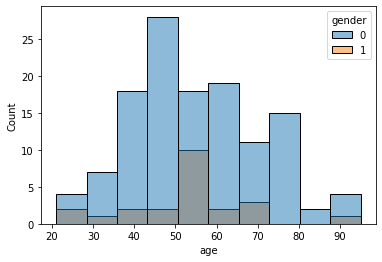

In [34]:
sns.histplot(x='age', data=df, hue='gender')

-
-

## Audio Files Download

In [35]:
directory = os.getcwd()
data_folder = 'raw_audio'

raw_audio_loc = '{}/{}'.format(directory, data_folder)

if not os.path.exists(raw_audio_loc):
    os.makedirs(raw_audio_loc)

os.chdir(raw_audio_loc)

Function to Download YouTube videos in .mp3 format

In [30]:
import youtube_dl

def yt_mp3(video_url):
  try:
    video_info = youtube_dl.YoutubeDL().extract_info(
        url = video_url,download=False
    )
    filename = f"{video_info['title']}.mp3"
    options={
        'format':'bestaudio/best',
        'keepvideo':False,
        'outtmpl':filename,
    }

    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([video_info['webpage_url']])
    return filename

  except:
    return 'error'

Function to Apply Filenames to Corresponding YoutTube Links after Download

In [ ]:
def yt_names(video_url):
    video_info = youtube_dl.YoutubeDL().extract_info(
        url = video_url,download=False
    )
    filename = f"{video_info['title']}.mp3"
    
    return filename

df['names'] = df['url'].apply(yt_names)

In [ ]:
df['names']

Note: YouTube blocks too many requests at a single time. (HTTP Error 429: Too Many Requests)

Function to Check Downloaded/Missing Files

In [ ]:
def downloaded(filename):
  try:
    wav, sr = librosa.load(filename)
    print("Loaded ", filename)
    return 'yes'
  except:
    print("Cannot Load ", filename)
    return 'no'

df['downloaded'] = df['names'].apply(downloaded)

In [ ]:
df['downloaded'].value_counts()

Change Column names

In [ ]:
cols = ['url', 'person', 'gender', 'age', 'filename', 'downloaded']
df.columns = cols

-
-

## Optional: Download Missing Data & Drop Unloadable Audio

In [ ]:
missing = df[ df['downloaded'] == 'no' ]

In [ ]:
missing.shape

In [ ]:
for index, data in tqdm(missing.iterrows()):
  name = yt_mp3(data['url'])

print('Complete')

In [ ]:
## 54 and 127 cannot be loaded/ so let's drop them
print(df.shape)
df = df.drop([54, 127])
print(df.shape)

-
-

## Convert .mp3 Audio to .wav

In [ ]:
location = raw_audio_loc

errors = []

for file in tqdm(files):
  wav = file.replace('.mp3', '.wav')
  try:
    sound = AudioSegment.from_file('{}/{}'.format(location, file))
    sound.export('{}/{}'.format(location, wav), format="wav")
  except:
    print('Failed: ', file)
    errors.append(file)

print('All mp3 files converted to wav')

Create column for wav file locations

In [ ]:
def rename_wav(filename):
  wav = filename.replace('.mp3', '.wav')
  return wav

df['filename_wav'] = df['filename'].apply(rename_wav)

-
-

## Split raw wav audio into 10 second clean splits

In [36]:
class SplitWavAudioAwsaf():
    def __init__(self, folder, filename, age, gender):
        self.folder = folder
        self.filename = filename
        self.age = age
        self.gender = gender
        
        self.filepath = folder + '/' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_min, to_min, split_filename):
        t1 = from_min * 1000
        t2 = to_min * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '/splits/' + split_filename, format="wav")
        return [split_filename, self.age, self.gender]
        
    def multiple_split(self, min_per_split):
        total_mins = math.ceil(self.get_duration())
        # print(total_mins)

        splits = []

        for i in tqdm(range(0, total_mins, min_per_split)):
            split_fn = str(i) + '_' + self.filename
            splits.append(self.single_split(i, i+min_per_split, split_fn))
            # print(str(i) + ' Done')
            if i == total_mins - min_per_split:
                print('All splited successfully')
        return splits[:-2]

In [ ]:
folder = raw_audio_loc

all_splits = []

for index, data in tqdm(df.iterrows()):
  try:
    filename = data['filename_wav']
    split = SplitWavAudioAwsaf(folder, filename, data['age'], data['gender'])
    single_splits = split.multiple_split(min_per_split=10)
    all_splits.append(single_splits)
  except:
    print('File doesnt exist')

Flatten Nest Split registers to 1-d list

In [ ]:
flat_list = []
for sublist in tqdm(all_splits):
    for item in sublist:
        flat_list.append(item)

Create new DataFrame from Split List

In [ ]:
split_df = pd.DataFrame(flat_list)
split_df.head()

Use Necessary Columns

In [ ]:
split_df.columns = ['filename', 'age', 'gender']
split_df.head()

In [ ]:
split_df.shape

In [ ]:
split_df['gender'].value_counts()

-
-

## Save Split Dataset to csv file

In [ ]:
split_df.to_csv('-agesex_dataset.csv', index=False)